In [1]:
import datajoint as dj
import numpy as np
import pandas as pd

dj.config['database.host'] = '127.0.0.1'
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'simple'

dj.config.save_local()
dj.conn()

[2023-04-20 16:56:17,338][INFO]: Connecting root@127.0.0.1:3306
[2023-04-20 16:56:17,380][INFO]: Connected root@127.0.0.1:3306


DataJoint connection (connected) root@127.0.0.1:3306

C:\Users\JSchw\anaconda3\envs\datajoint_test\lib\inspect.py:350: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
C:\Users\JSchw\anaconda3\envs\datajoint_test\lib\inspect.py:350: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
C:\Users\JSchw\anaconda3\envs\datajoint_test\lib\inspect.py:350: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)


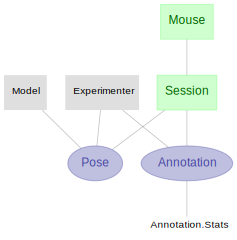

In [21]:
from tables import schema, Mouse, Session, Experimenter, Annotation, Pose, Model

dj.Diagram(schema)

In [4]:
# add dummy entry to lookup tables

Experimenter.insert1((0, "JensBlack", "M"), skip_duplicates = True)
Model.insert1((0, "TestModelName", "SingleInstance","SLEAP", "2022-10-20", "Test entry for model description. Date is fake."), skip_duplicates = True)

In [5]:
# Add real mice
#test file: T332-27072022-204839

mice = (332, "1900-01-01", "M" , "C57BL6")

Mouse.insert1(mice, skip_duplicates = True)

sessions = (332, 0, "2022-07-27-20:48:39", 0, "NaN", 30,"D:\COLLABDATA\Seizures\seizure_examples\package\T332-27072022-204839.avi.predictions.analysis.h5", 0, "D:\COLLABDATA\Seizures\seizure_examples\package\T332-27072022-204839_No focal subject.csv", "BORIS")

Session.insert1(sessions, skip_duplicates = True)


In [6]:
Mouse * Session

mouse_id Unique animal ID,session_id id of experiment,dob date of birth,sex sex,genotype genotype of animal #TODO: should be restricted to Lookup table,session_time time of experiment #todo: change to datetime,"experimenter_id id of experimenter, linking to experimenter table",video_path path to video file,video_fps fps of recorded video file,pose_path path to pose file,pose_model_id unique id linking pose file to model,annotation_path path to annotation file,annotation_origin origin of annotation files (e.g. BORIS)
332,0,1900-01-01,M,C57BL6,2022-07-27 20:48:39,0,NaN,30,D:\COLLABDATA\Seizures\seizure_examples\package\T332-27072022-204839.avi.predictions.analysis.h5,0,D:\COLLABDATA\Seizures\seizure_examples\package\T332-27072022-204839_No focal subject.csv,BORIS


In [19]:
#populate the Import tables
Annotation.populate()
Pose.populate()

recover the pose estimation data from that session and convert it back into a pd.Dataframe

In [10]:
mouse_id = 332
session_id = 0
experimenter_id = 0

pose_arr, keypoints = (Pose & f"mouse_id = {mouse_id}" & f"session_id = {session_id}").fetch1("pose", "keypoints")
#convert keypoints back to list
keypoints = keypoints.split(", ")

model_id = (Session & f"experimenter_id = {experimenter_id}" & f"session_id = {session_id}").fetch1("pose_model_id")

model_name = (Model & f'model_id = {model_id}').fetch1("name")

df = pd.DataFrame(pose_arr)
df.columns =pd.MultiIndex.from_product([[model_name], keypoints, ["x", "y", "likelihood"]]
                                       , names = ["model", "keypoints", "coords"]
                                       )
df



model     TestModelName                                                 \
keypoints      ear_left                          ear_right               
coords                x           y likelihood           x           y   
0            768.060303  303.915894        1.0  680.155823  316.045258   
1            771.877014  303.880249        1.0  680.094482  316.013702   
2            771.963501  303.849487        1.0  680.089600  316.009766   
3            771.918884  311.881409        1.0  679.972961  324.072968   
4            772.111572  312.031097        1.0  680.257629  332.042816   
...                 ...         ...        ...         ...         ...   
67974        467.992462  455.969635        1.0  540.142639  508.061432   
67975        467.996948  455.955078        1.0  540.133118  508.061707   
67976        468.017242  455.984650        1.0  540.130676  508.066193   
67977        468.003479  455.954437        1.0  540.130127  508.057343   
67978        467.998840  455.959808        1.0  540.118774  508.061920   

model                                                                ...  \
keypoints               hip_left                          hip_right  ...   
coords    likelihood           x           y likelihood           x  ...   
0                1.0  731.987000  187.944641        1.0  651.943848  ...   
1                1.0  727.726501  187.869583        1.0  651.749695  ...   
2                1.0  727.723083  187.945724        1.0  755.755798  ...   
3                1.0  772.284790  216.150909        1.0  652.183411  ...   
4                1.0  772.113708  220.072205        1.0  655.957764  ...   
...              ...         ...         ...        ...         ...  ...   
67974            1.0  404.054657  544.025330        1.0  500.132202  ...   
67975            1.0  404.045929  544.053162        1.0  500.127045  ...   
67976            1.0  404.048492  544.046570        1.0  500.147461  ...   
67977            1.0  404.052124  544.034668        1.0  500.168732  ...   
67978            1.0  404.053284  544.008484        1.0  500.168945  ...   

model                                                                \
keypoints       neck        nose                          tail_base   
coords    likelihood           x           y likelihood           x   
0                1.0  743.828979  360.086975        1.0  679.949097   
1                1.0  743.941650  359.961365        1.0  676.098572   
2                1.0  747.831116  356.064423        1.0  679.961304   
3                1.0  752.175659  348.292480        1.0  679.933960   
4                1.0  760.119446  348.020355        1.0  679.947388   
...              ...         ...         ...        ...         ...   
67974            1.0  536.151672  424.166473        1.0  431.917908   
67975            1.0  536.143555  424.156769        1.0  431.914917   
67976            1.0  536.155273  424.158051        1.0  431.915771   
67977            1.0  536.156494  424.161377        1.0  431.914581   
67978            1.0  536.163025  424.167145        1.0  431.912323   

model                                                                
keypoints                           tail_tip                         
coords              y likelihood           x           y likelihood  
0          167.877228        1.0  671.543945  375.730286        0.0  
1          164.051056        1.0  671.543945  375.730286        0.0  
2          167.911652        1.0  671.543945  375.730286        0.0  
3          167.934067        1.0  671.543945  375.730286        0.0  
4          167.910538        1.0  671.543945  375.730286        0.0  
...               ...        ...         ...         ...        ...  
67974      631.880615        1.0  420.075562  868.138489        1.0  
67975      631.880371        1.0  420.080322  868.137451        1.0  
67976      631.881226        1.0  420.079742  868.143066        1.0  
67977      631.880798        1.0  420.077850  868.144592       

Get some descriptive statistics from the database by fetching a dj.Part of Annotation

In [20]:
Annotation.Stats()

mouse_id Unique animal ID,session_id id of experiment,experimenter_id Unique experimenter ID,behavior_id unique behavior id,total_frames total number of frames per behavior,total_perc perc. compared to total length of session,total_time total time in seconds
332,0,0,Eat,1197,0.0176081,39.9
332,0,0,Freeze,11325,0.166593,377.5
332,0,0,Groom,7305,0.107458,243.5
332,0,0,Head Nodding,549,0.00807591,18.3
332,0,0,Investigate,40407,0.594395,1346.9
332,0,0,other,1101,0.0161959,36.7
332,0,0,Rearing,231,0.00339806,7.7
332,0,0,Rest,3021,0.0444395,100.7
332,0,0,Seizure,2844,0.0418358,94.8
